# Stiffness Analysis

- I believe Adams-Moulton is sometimes unstable because it requires the use of Adams-Bashforth, which is bad. I should make a different implementation of Moulton without using Bashforth and compare this to the standard Predictor-Corrector.

- Since RKF45 is the only method with a variable step-size, it might not fit well in a graph with the other methods.

- RKF45 is currently broken fix it.

- I can probably improve adams-bashforth by improving the calculation for delF. Instead of computing it at each iteration I could maybe save the previous steps.

https://chatgpt.com/c/67020ba4-17a8-800b-acfb-d19ca4157141?model=gpt-4o

^ Here's valuable analysis by o1

I want to make a comprehensive analysis of stiffness and comparison of all the methods I've implemented.

Some potentially useful resources:

- Section 4.6 of the book
- https://en.wikipedia.org/wiki/Stiff_equation
- https://chatgpt.com/c/6701ad42-b3ac-800b-88ef-2390f6902bcd

The 3rd is a convo with GPT-4 where it lists many useful stiff ODEs.

In [144]:
import numpy as np
import matplotlib.pyplot as plt

## Implementation of main algorithms

### Euler

In [145]:
def euler_method(F, t0, x0, h, n_steps):
    dim = len(x0)
    t_end = t0 + h*n_steps
    t = np.arange(t0, t_end, h)
    x = np.zeros((n_steps, dim))
    x[0] = x0

    for n in range(1, n_steps):
        x[n] = x[n-1] + h * F(t[n-1], x[n-1])

    return t, x

### Runge-Kutta

In [146]:
def RK_method(F, t0, x0, h, n_steps, a, b, c):
    dim = len(x0)
    l = len(b)
    t = np.arange(t0, t0 + h*n_steps, h)
    x = np.zeros((n_steps, dim))
    x[0] = x0
    k = np.zeros((l, dim))

    for n in range(1, n_steps):
        k[0] = F(t[n-1], x[n-1])
        for i in range(1, l):
            t_i = t[n-1] + h * c[i]
            x_i = x[n-1] + h * np.dot(a[i-1][:i], k[:i])
            k[i] = F(t_i, x_i)
        x[n] = x[n-1] + h * np.dot(b, k)

    return t, x

In [147]:
# 3-stage Runge-Kutta
def RK3(F, t0, x0, h, n_steps):
    a = np.array(
        [[0.5, 0], [-1, 2]]
    )
    b = np.array([1/6, 4/6, 1/6])
    c = np.array([0, 0.5, 1])
    return RK_method(F, t0, x0, h, n_steps, a, b, c)

In [148]:
# Classical (4-stage) Runge-Kutta
def RK4(F, t0, x0, h, n_steps):
    a = np.array(
        [[0.5, 0, 0],
         [0, 0.5, 0],
         [0, 0, 1]]
    )
    b = np.array([1/6, 2/6, 2/6, 1/6])
    c = np.array([0, 0.5, 0.5, 1])
    return RK_method(F, t0, x0, h, n_steps, a, b, c)

### RKF45

In [149]:
# Lists with Butcher tableau for RKF45
A = np.array([
    [1/4, 0, 0, 0, 0],
    [3/32, 9/32, 0, 0, 0],
    [1932/2197, -7200/2197, 7296/2197, 0, 0],
    [439/216, -8, 3680/513, -845/4104, 0],
    [-8/27, 2, -3544/2565, 1859/4104, -11/40]
])
B4 = np.array([25/216, 0, 1408/2565, 2197/4104, -1/5, 0])
B5 = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
C = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])

# Bounds so algorithm always stops running
MAX_ERROR = 1e-6
EPSILON = 1e-15

In [150]:
# Dynamically compute the stepsize (h)
def RKF45_step(F, t, x, h, max_iterations=5):
	dim = len(x)
	l = len(C)
	k = np.zeros((l, dim))

	k[0] = F(t, x)
	
	for _ in range(max_iterations):
		for i in range(1, l):
			k[i] = F(t + h * C[i], x + h * np.dot(A[i-1, :i], k[:i]))
		# Compute next time
		t_next = t + h # is this correct? should't t_next be based on h_next? no, this here is correct

		# Compute next x with order 4 and 5 methods
		x4 = x + h * np.dot(B4, k)
		x5 = x + h * np.dot(B5, k)

		# Compute error
		error = np.linalg.norm(x4 - x5)

		# Update h
		h_next = h * np.power(MAX_ERROR / (2 * max(error, EPSILON)), 1/4)
		
		# Break if error is below threshold
		if error <= MAX_ERROR:
			break

	return t_next, x4, h_next

In [151]:
# The main function
def RKF45(F, t0, x0, h0, t_final):
    # Initialize stuff
    t, x, h = [t0], [x0], [h0]

    while t[-1] < t_final:
        t_next, x_next, h_next = RKF45_step(F, t[-1], x[-1], h[-1])
        t.append(t_next)
        x.append(x_next)
        h.append(h_next)
        
    return np.array(t), np.vstack(x), np.array(h)

### Adams-Bashforth (explicit)

In [152]:
def compute_a_adams(k):
    # return ndarray of a[i]'s
    # which are the integral of pochhammer over i!, 0 <= i < k
    # the book gives a recursive formula to compute a[i]
    a = np.ones((k))
    for i in range(1, k):
        for j in range(i):
            a[i] -= a[j] / (i+1-j)
            
    return a

In [153]:
def adams_bashforth(F, t0, x0, h, n_steps, k):
    dim = len(x0)
    t = np.arange(t0, t0 + h*n_steps, h)
    x = np.zeros((n_steps, dim))
    delF = np.zeros((n_steps, k, dim))
    a = compute_a_adams(k)

    # Compute first k steps with RKF45
    _, x_first_k = RK4(F, t0, x0, h, k)
    x[:k] = x_first_k
    
    # Compute first k-1 delFs
    for n in range(k-1):
        delF[n, 0] = F(t[n], x[n])
        for i in range(1, n+1):
            delF[n, i] = delF[n, i-1] - delF[n-1, i-1]

	# Main loop
    for n in range(k, n_steps):
        delF[n-1, 0] = F(t[n-1], x[n-1])
        for i in range(1, k):
            delF[n-1, i] = delF[n-1, i-1] - delF[n-2, i-1]
        x[n] = x[n-1] + h * np.dot(a, delF[n-1])
    
    return t, x

### Adams-Moulton (implicit)

I've implemented a predictor-corrector method, namely PECE, in which delF[n] is re-evaluated with the correction. It works much better than simple PEC, which does not update delF[n] and therefore diverges often.

In [154]:
def compute_b_adams(k):
	# return ndarray of b[i]s
	# whose definition is in the book p.132
	# which is given by a recursive formula
	b = np.zeros((k))
	b[0] = 1
	for i in range(1, k):
		for j in range(i+1):
			b[i] -= b[i-j] / (j + 1)
	
	return b

In [273]:
def adams_moulton(F, t0, x0, h, n_steps, k, n_corrections=1):
	# Setup
	dim = len(x0)
	t = np.arange(t0, t0 + h*n_steps, h)
	x = np.zeros((n_steps, dim))
	delF = np.zeros((n_steps, k, dim))
	a = compute_a_adams(k)
	b = compute_b_adams(k)

	# First k steps using RK4
	_, x_first_k = RK4(F, t0, x0, h, k)
	x[:k] = x_first_k

	# Compute first k delFs
	for n in range(k):
		delF[n, 0] = F(t[n], x[n])
		for i in range(1, n+1):
			delF[n, i] = delF[n, i-1] - delF[n-1, i-1]

	# Main loop
	for n in range(k, n_steps):
		# Compute initial prediction of x[n] with Adams-Bashforth
		x[n] = x[n-1] + h * np.dot(a, delF[n-1])

		# This is a 'P(EC)^(n_corrections)E' predictor corrector
		# P: Predict with Adams-Bashforth
		# EC: Evaluate delF + Correct with Adams-Moulton
		# E: Evaluate delF one final time with improved approximation
		for _ in range(n_corrections):
			# Evaluate delF
			delF[n, 0] = F(t[n], x[n])
			for i in range(1, k):
				delF[n, i] = delF[n, i-1] - delF[n-1, i-1]

			# Now correct approximation with Adams-Moulton
			x[n] = x[n-1] + h * np.dot(b, delF[n])

		# Re-evaluate delF[n] with improved approximation for x[n]
		delF[n, 0] = F(t[n], x[n])
		for i in range(1, k):
			delF[n, i] = delF[n, i-1] - delF[n-1, i-1]

	return t, x

### Implicit Euler

In [274]:
def newtons_method(x1, f, df, n):
    # Initial guess
    x = x1
    for i in range(n):
        if f(x) != 0 and df(x) != 0:
            x -= f(x) / df(x)
        else:
            return x
    return x

In [275]:
def implicit_euler(F, dF_dx, t_span, x0, n_steps, k):
    t_start, t_end = t_span
    h = (t_end - t_start) / (n_steps - 1)

    t = np.linspace(t_start, t_end, n_steps)
    x = np.zeros(n_steps)
    x[0] = x0
    
    for n in range(1, n_steps):
        f = lambda y: x[n-1] + h * F(t[n], y) - y
        df = lambda y: h * dF_dx(t[n], y) - 1
        x[n] = newtons_method(x[n-1], f, df, k)
    
    return t, x

### Backward differentiation

In [276]:
def multidimensional_newtons_method(x_guess, f, df, n):
	# initial guess
	x = x_guess

	# Apply Newton's method n times
	for _ in range(n):
		A = df(x)
		b = -f(x)
		# New estimate for x
		x += np.linalg.solve(A, b)
	
	return x

def func(x):
	x, y = x[0], x[1]
	fx = x**2 - 1
	fy = y**3 - 8
	return np.array([fx, fy])

def jac(x):
	x, y = x[0], x[1]
	return np.array([[2*x, 0], [0, 3*y**2]])

print(multidimensional_newtons_method([10., 10.], func, jac, 7))

[1.         2.00000097]


## Many stiff ODEs

Add lots of stiff ODEs and compare all the methods with them.

### Function to display solutions

Add option when ODE is 3D to display all 3 coordinates.

In [277]:
def display_solutions(F, t0, x0, h, n_steps, k=3, n_corrections=1, F_name='', display='t_x', methods=['Euler', 'RK3', 'RK4', 'RKF45', 'Adams-Bashforth', 'Adams-Moulton']):
	for method in methods:
		if method == 'Euler':
			t, x = euler_method(F, t0, x0, h, n_steps)
			if display == 't_x':
				plt.plot(t, x[:, 0], label='Euler')
			elif display == 'x1_x2':
				plt.plot(x[:, 0], x[:, 1], label='Euler')

		elif method == 'RK3':
			t, x = RK3(F, t0, x0, h, n_steps)
			if display == 't_x':
				plt.plot(t, x[:, 0], label='RK3')
			elif display == 'x1_x2':
				plt.plot(x[:, 0], x[:, 1], label='RK3')
			
		elif method == 'RK4':
			t, x = RK4(F, t0, x0, h, n_steps)
			if display == 't_x':
				plt.plot(t, x[:, 0], label='RK4')
			elif display == 'x1_x2':
				plt.plot(x[:, 0], x[:, 1], label='RK4')
			
		elif method == 'RKF45':
			t, x, _ = RKF45(F, t0, x0, h, t0 + h*n_steps) # It might be interesting to unpack 'h' too
			if display == 't_x':
				plt.plot(t, x[:, 0], label='RKF45')
			elif display == 'x1_x2':
				plt.plot(x[:, 0], x[:, 1], label='RKF45')
			
		elif method == 'Adams-Bashforth':
			t, x = adams_bashforth(F, t0, x0, h, n_steps, k)
			if display == 't_x':
				plt.plot(t, x[:, 0], label='Adams-Bashforth')
			elif display == 'x1_x2':
				plt.plot(x[:, 0], x[:, 1], label='Adams-Bashforth')
			
		elif method == 'Adams-Moulton':
			t, x = adams_moulton(F, t0, x0, h, n_steps, k, n_corrections)
			if display == 't_x':
				plt.plot(t, x[:, 0], label='Adams-Moulton')
			elif display == 'x1_x2':
				plt.plot(x[:, 0], x[:, 1], label='Adams-Moulton')
			
	if display == 't_x':
		plt.xlabel('Time (t)')
		plt.ylabel('Solution (x)')
	elif display == 'x1_x2':
		plt.xlabel('Solution (x)')
		plt.ylabel('Solution (y)')
		
	plt.title(f'{F_name} solutions using Different Numerical Methods')
	plt.legend()
	plt.grid(True)
	plt.show()

### Basic Riccati

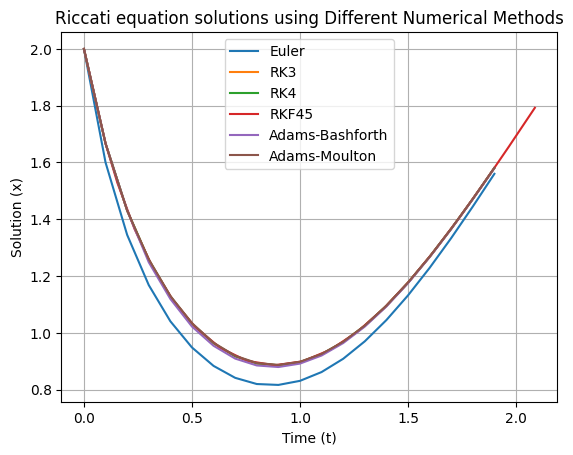

In [278]:
def riccati(t, x):
    return np.array([t**2 - x**2])

display_solutions(
	F=riccati,
	t0=0,
	x0=np.array([2]),
	h=0.1,
	n_steps=20,
	k=3,
	F_name="Riccati equation",
)

### Exponential decay

Surprising discovery: for P(EC)^(n)E methods, n odd is good and n even is bad. Wow.

In [370]:
def plot_PECE(F, t0, x0, h, n_steps, ks=[1], n_corrections=[1]):
	for k in ks:
		for c in n_corrections:
			t, x = adams_moulton(F, t0, x0, h, n_steps, k, c)
			plt.plot(t, x[:, 0], label=f'k={k}, c={c}')
	
	plt.xlabel('Time (t)')
	plt.ylabel('Solution (x)')
	plt.title('ODE solutions using Adams-Moulton with different numbers of k and c')
	plt.legend()
	plt.grid(True)
	plt.show()

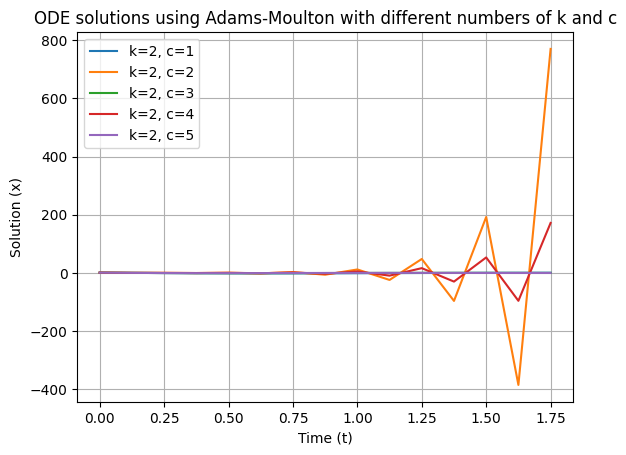

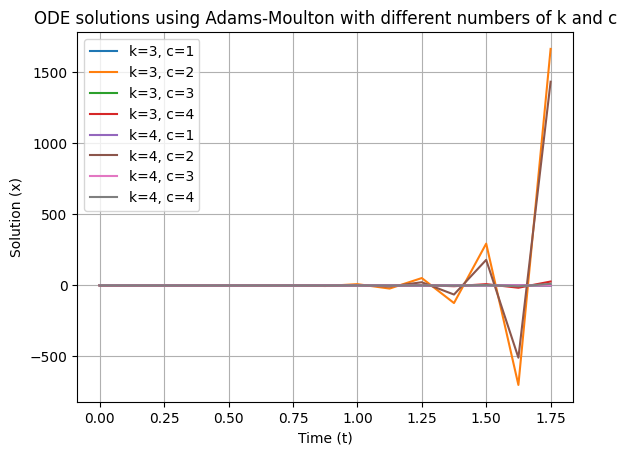

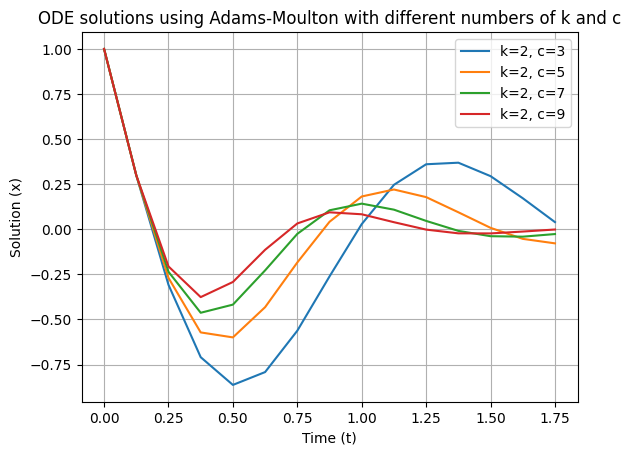

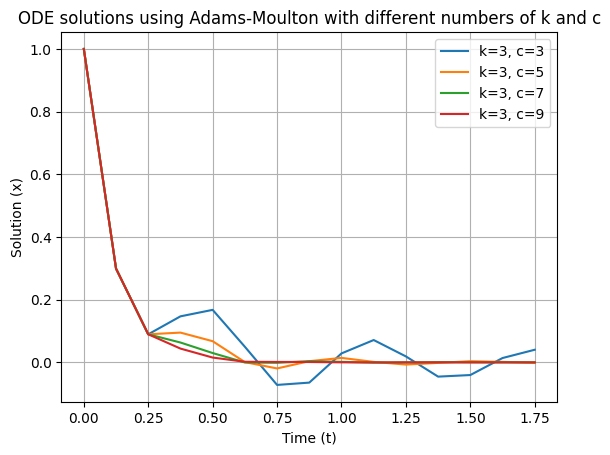

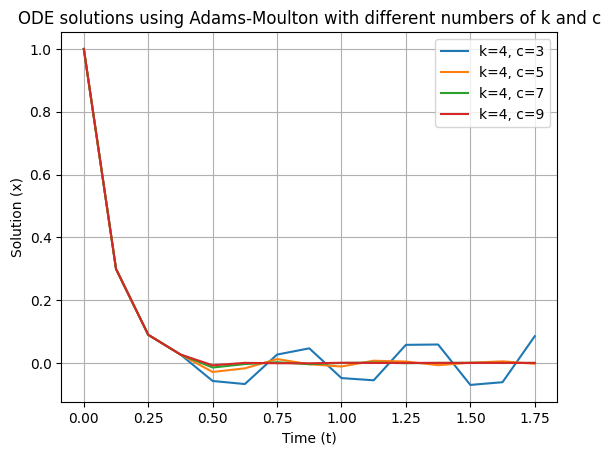

In [371]:
decay_rate = 15

def exp_decay(t, x):
	Dx = - decay_rate * x[0]
	return np.array([Dx])

t0 = 0
x0 = np.array([1])
h = 0.125
n_steps = 15
k = 3

plot_PECE(exp_decay, t0, x0, h, n_steps, [2], [1, 2, 3, 4, 5])
plot_PECE(exp_decay, t0, x0, h, n_steps, [3, 4], [1, 2, 3, 4])
plot_PECE(exp_decay, t0, x0, h, n_steps, [2], [3, 5, 7, 9])
plot_PECE(exp_decay, t0, x0, h, n_steps, [3], [3, 5, 7, 9])
plot_PECE(exp_decay, t0, x0, h, n_steps, [4], [3, 5, 7, 9])

### Math stackexchange stiff ODE

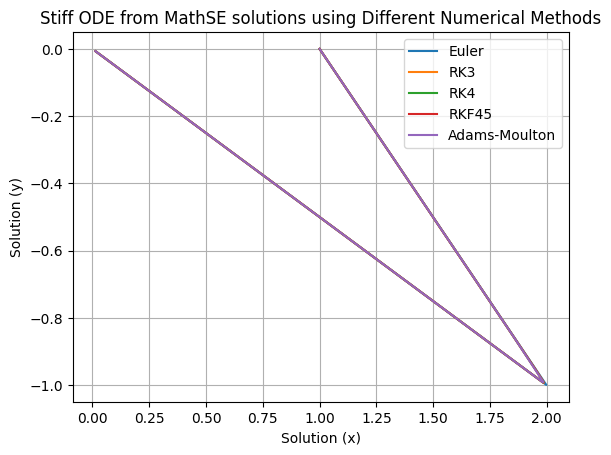

In [372]:
def mathse_stiff(t, x):
	x1, x2 = x
	Dx1 = 998*x1 + 1998*x2
	Dx2 = -999*x1 - 1999*x2
	return np.array([Dx1, Dx2])

display_solutions(
	F=mathse_stiff,
	t0=0,
	x0=np.array([1, 0]),
	h=0.001,
	n_steps=5000,
	k=3,
	F_name="Stiff ODE from MathSE",
	display='x1_x2',
	methods=['Euler', 'RK3', 'RK4', 'RKF45', 'Adams-Moulton']
)

### Van der Pol with high 'mu'

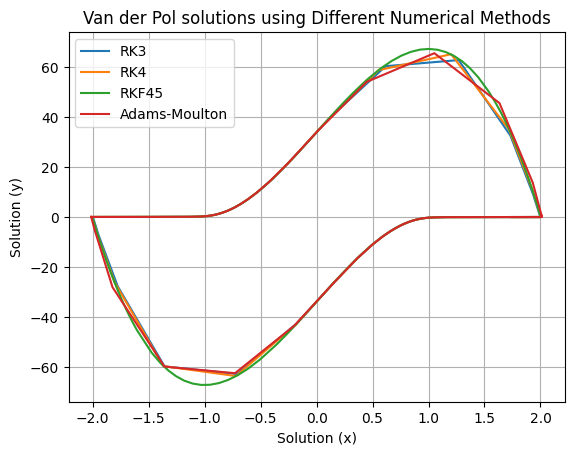

In [376]:
def van_der_pol(t, x, mu):
	x1, x2 = x
	Dx1 = x2
	Dx2 = -x1 - mu * (x1**2 - 1) * x2
	return np.array([Dx1, Dx2])

display_solutions(
	F=lambda t, x: van_der_pol(t, x, 50),
	t0=0,
	x0=[2, 0],
	h=0.01,
	n_steps=10000,
	k=3,
	n_corrections=5,
	F_name='Van der Pol',
	display='x1_x2',
	methods=['RK3', 'RK4', 'RKF45', 'Adams-Moulton']
)

### Robertson's ODE

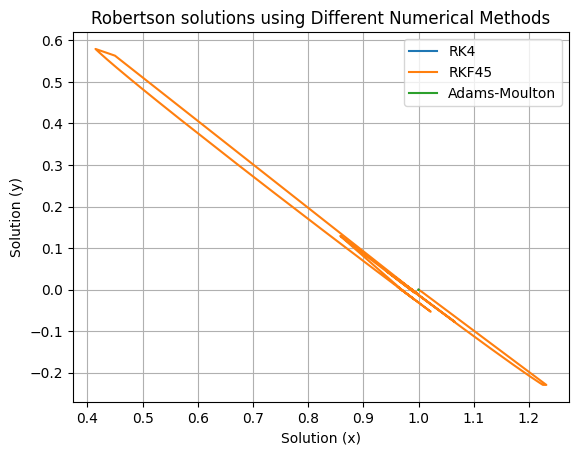

In [386]:
def robertson(t, X):
	x, y, z = X
	Dx = -0.04 * x + 10**4 * y * z
	Dy = 0.04 * x - 10**4 * y * z - 3*10**4 * y**2
	Dz = 3*10**7 * y**2
	return np.array([Dx, Dy, Dz])

display_solutions(
	F=robertson,
	t0=0,
	x0=[1, 0, 0],
	h=0.001,
	n_steps=2000,
	k=3,
	n_corrections=7,
	F_name='Robertson',
	display='x1_x2',
	methods=['RK4', 'RKF45', 'Adams-Moulton']
)